In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
import numpy as np
import scipy.stats as sps
from scipy.spatial.distance import cdist

from sklearn import linear_model
import statsmodels.api as sm

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

This part is very much like the first part of the challenge but at the same time very different. Now we use the cities in EU, AS, OC and AF as a train set and cities in NA and SA as test set. So we essentially have a training set and test set that could be very different from one another, they might have different characteristics so it's difficult to use a validation set in our model. Therefore we want to make a very general model to ensure that the transferability is at maximum.

In [2]:
df = pd.read_excel('Cities.xlsx', index_col=0)
df = df.set_index('City')
dfALL = df.copy()

df = df.groupby("Typology").transform(lambda x: x.fillna(x.mean()))
df.insert(4, "Continents", dfALL["Continents"], True)

df = df.groupby("Continents").transform(lambda x: x.fillna(x.mean()))
df.insert(2, "Typology", dfALL["Typology"], True) 
df.insert(3, "Country", dfALL["Country"], True)
df.insert(4, "Continents", dfALL["Continents"], True)


dfSA = df.loc[df['Continents'] == 'SA']
dfNA = df.loc[df['Continents'] == 'NOAM']


dfEU = df.loc[df['Continents'] == 'EU']
dfAS = df.loc[df['Continents'] == 'AS']
dfOC = df.loc[df['Continents'] == 'OC']
dfAF = df.loc[df['Continents'] == 'AF']

dfAM = pd.concat([dfSA, dfNA])
dfROTW = pd.concat([dfEU, dfAS, dfOC, dfAF])

training = dfROTW
test = dfAM

As the training variables we choose the same the correlation cut off as in the first part. But now we have no dummy variables, as the typologies are mostly grouped together in the same continents. The continents dummies would completely useless in this case.

In [3]:
correlation = training[training.columns[:]].corr()['CO2 Emissions per Capita (metric tonnes)']
corre_df = correlation.to_frame()
corre_df = corre_df.rename(columns={'CO2 Emissions per Capita (metric tonnes)': 'CO2corr'})
corre_df1 = corre_df[corre_df.CO2corr >= 0.4]
corre_df2 = corre_df[corre_df.CO2corr <= -0.4]
corre_df = corre_df1.append(corre_df2)

corre_df = corre_df.drop(index='CO2 Emissions per Capita (metric tonnes)')
corre_df = corre_df.drop(index='Pollution Index ')
corre_df = corre_df.drop(index='Congestion AM Peak (%)')

listi = corre_df.T.columns.tolist()

Lets check the correlation between the variables as in part 1 and throw out some highly correlated ones.

In [4]:
training[listi].corr().head()

,clusterID,Car Modeshare (%),Urbanization Rate 2015 (%),GDP per Capita (USD),Local Purchasing Power Index,Life Expectancy (years),Internet Penetration,Digital Penetration,Innovation Index,Smartphone Penetration (%),Development Factor,Walking Modeshare (%),Congestion (%),Population Density (per sq. km),Unemployment Rate (%),Congestion Factor
clusterID,1.000000,0.197035,0.423992,0.560015,0.420139,0.698697,0.555268,0.593012,0.605997,0.731427,0.628637,-0.392316,-0.296611,-0.381323,-0.535242,-0.458794
Car Modeshare (%),0.197035,1.000000,0.556228,0.460871,0.603441,0.467813,0.519750,0.588271,0.393729,0.520452,0.574393,-0.601853,-0.452090,-0.349156,-0.296749,-0.690081
Urbanization Rate 2015 (%),0.423992,0.556228,1.000000,0.684252,0.577262,0.710113,0.801748,0.830461,0.600121,0.701891,0.800214,-0.404772,-0.480928,-0.447926,-0.466137,-0.625171
GDP per Capita (USD),0.560015,0.460871,0.684252,1.000000,0.742784,0.677634,0.781904,0.828587,0.783367,0.634130,0.917961,-0.360295,-0.466149,-0.445850,-0.393907,-0.639573
Local Purchasing Power Index,0.420139,0.603441,0.577262,0.742784,1.000000,0.534476,0.642272,0.691955,0.670322,0.525928,0.780021,-0.327263,-0.522654,-0.339888,-0.338721,-0.723338


In [5]:
listi.remove('Digital Penetration') #Highly correlated with a lot of attributes
listi.remove('Development Factor') #Highly correlated with a lot of attributes

features = listi
target = 'CO2 Emissions per Capita (metric tonnes)'
x_train = training[features]
y_train = training[target]
x_test = test[features]
y_test = test[target]

Since we want to use a very general model as discussed above, we use the sklearn Elastic Net linear model. Which is a linear regression with combined L1 and L2 priors as regularizer. That model uses L1 and L2 penalty terms to ensure that none of the coefficiants in the model will be to dominant. Therefore we also have to standardize the data first.


In [6]:
X_mean = x_train.mean(axis=0)
X_std = x_train.std(axis=0)
X_train = (x_train - X_mean) / X_std
X_test = (x_test - X_mean) / X_std

Linear regression score for the train set 0.5238675712061756
Linear regression score for the test set 0.46624504924517374
The root mean squared error is 5.672172212950439


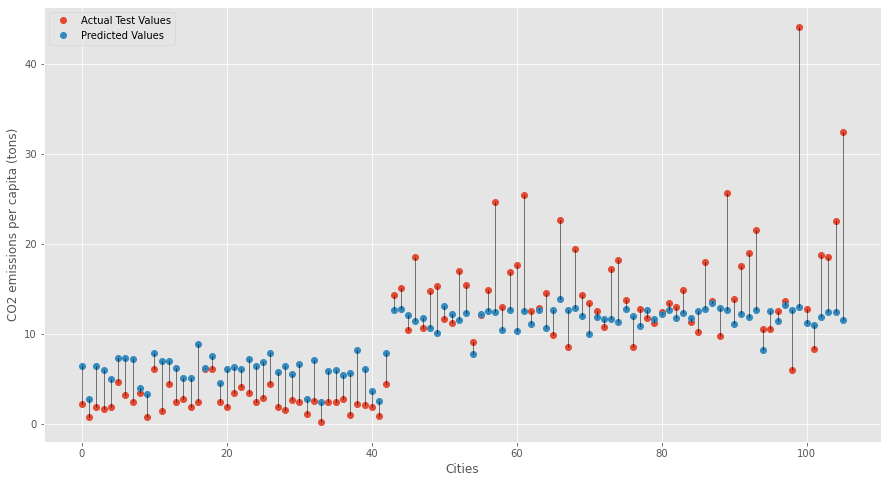

In [7]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Linear regression score for the train set", regr.score(X_train, y_train))
print("Linear regression score for the test set" , regr.score(X_test, y_test))
rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

print("The root mean squared error is", rmse)


fig, ax = plt.subplots()
test, = ax.plot(np.arange(0,len(y_test)), y_test, label='Actual Test Values', marker='o', linestyle="None")
pred, = ax.plot(np.arange(0,len(y_test)),y_pred, label='Predicted Values', marker='o', linestyle="None")
for i in range(len(y_test)):
    ax.plot([i,i],[y_pred[i], y_test[i]], c="black", linewidth=0.5)

ax.set(xlabel='Cities', ylabel='CO2 emissions per capita (tons)',
       title='')
plt.legend(handles=[test, pred])
plt.show()




Now our regression scores are more similar for the test and training sets but the model performance is clearly lower as was suspected. The first 43 datapoints are cities in South America and the rest are in North America. We can see that there is a clear difference between the two continents. From the plot it appears that the model is doing much worse at predicting CO2 values in North America than South America. Again, Edmonton and New Orleans are big outliers in the data. We can see that the prediction is not responding well to oscillations in the North America data and appears to be underfitted.